# In-Tandem NNs (NN$\Delta$NN)
Using a CGCNN to predict the error of another CGCNN.

# Initialize and Train CGCNN

Automatically search for an NVIDIA GPU and use it. If not, then use CPU

In [1]:
import torch
%env CUDA_VISIBLE_DEVICES=2


if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Using GPU')
else:
    device = 'cpu'
    print('Using CPU')

env: CUDA_VISIBLE_DEVICES=2
Using GPU


In [2]:
import pickle


# Label to use for this model in the plots
model_name = 'NN$\Delta$NN'

with open('../preprocessing/sdt/gasdb/feature_dimensions.pkl', 'rb') as file_handle:
    orig_atom_fea_len, nbr_fea_len = pickle.load(file_handle)

with open('../preprocessing/splits_gasdb.pkl', 'rb') as file_handle:
    splits = pickle.load(file_handle)
    

docs_train, docs_val, docs_test = splits['docs_train'], splits['docs_val'], splits['docs_test']
sdts_train, sdts_val, sdts_test = splits['sdts_train'], splits['sdts_val'], splits['sdts_test']
targets_train, targets_val, targets_test = splits['targets_train'], splits['targets_val'], splits['targets_test']

# Define all the adsorbates
adsorbates = list({doc['adsorbate'] for doc in docs_val})
adsorbates.sort()

# Where we put the intermediate results for this notebook
prefix = 'gasdb_pooled/'

##### Split train into train portion and error portion

In [3]:
err_start_ind = int(.9 * len(sdts_train))

sdts_err = sdts_train[err_start_ind:]
sdts_train = sdts_train[:err_start_ind]

targets_err_true = targets_train[err_start_ind:]
targets_train = targets_train[:err_start_ind]

##### Initialize the CGCNN `net` class, then train model, or load pre-trained results

In [4]:
from torch.optim import Adam
# import skorch.callbacks.base
from skorch import callbacks  # needs skorch >= 0.4  
from skorch import NeuralNetRegressor
from skorch.dataset import CVSplit
from cgcnn.model import CrystalGraphConvNet
from cgcnn.data import collate_pool, MergeDataset


# Callback to checkpoint parameters every time there is a new best for validation loss
cp = callbacks.Checkpoint(monitor='valid_loss_best', fn_prefix=prefix+'valid_best_')

# Callback to load the checkpoint with the best validation loss at the end of training
class train_end_load_best_valid_loss(callbacks.base.Callback):
    def on_train_end(self, net, X, y):
        net.load_params(prefix+'valid_best_params.pt')
load_best_valid_loss = train_end_load_best_valid_loss()

# Callback to set the learning rate dynamically
LR_schedule = callbacks.lr_scheduler.LRScheduler('MultiStepLR', milestones=[100], gamma=0.1)

net = NeuralNetRegressor(
    CrystalGraphConvNet,
    module__orig_atom_fea_len=orig_atom_fea_len,
    module__nbr_fea_len=nbr_fea_len,
    batch_size=214,
    module__classification=False,
    lr=0.0056,
    max_epochs=150,
    module__atom_fea_len=46,
    module__h_fea_len=83,
    module__n_conv=8,
    module__n_h=4,
    optimizer=Adam,
    iterator_train__pin_memory=True,
    iterator_train__num_workers=0,
    iterator_train__collate_fn=collate_pool,
    iterator_train__shuffle=True,
    iterator_valid__pin_memory=True,
    iterator_valid__num_workers=0,
    iterator_valid__collate_fn=collate_pool,
    iterator_valid__shuffle=False,
    device=device,
    criterion=torch.nn.L1Loss,
    dataset=MergeDataset,
    callbacks=[cp, load_best_valid_loss, LR_schedule]
)
# Initialize CGCNN
net.initialize()

# Note: to re-train:
# net.fit(sdts_train, targets_train)

# Note: to restart training in case first round was cut off
# net.partial_fit(sdts_train, targets_train)

# Load the pre-trained model
net.load_params(f_history=prefix+'valid_best_history.json',
                f_optimizer=prefix+'valid_best_optimizer.pt', 
                f_params=prefix+'valid_best_params.pt')

# Second CGCNN to Predict Error on Held Out Data

In [5]:
# Imports
import numpy as np

Get the output of the CGCNN. We cache just to save time.

In [6]:
%load_ext ipycache

/zfsauton/home/willie/miniconda3/envs/ubench36/lib/python3.6/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated since IPython 4.0. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/zfsauton/home/willie/miniconda3/envs/ubench36/lib/python3.6/site-packages/ipycache.py:17: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils.traitlets import Unicode


In [7]:
%%cache cgcnn_err_predictions.pkl targets_err_pred

# Use CGCNN-1 to predict targets for sdts_err
targets_err_pred = net.predict(sdts_err).reshape(-1)

[Skipped the cell's code and loaded variables targets_err_pred from file '/zfsauton/home/willie/proj/uncertainty_benchmarking/NNdNN/cgcnn_err_predictions.pkl'.]


In [8]:
# Find errors (difference) with targets_err_true, and define this difference to be targets_err
targets_err = np.abs(targets_err_pred.flatten() - targets_err_true.flatten()).reshape(-1,1)

##### Initialize the error CGCNN network, then train model, or load pre-trained results

In [9]:
# Callback to checkpoint parameters every time there is a new best for error-set loss
cp = callbacks.Checkpoint(monitor='valid_loss_best', fn_prefix='err_best_')

# Callback to load the checkpoint with the best error-set loss at the end of training
class train_end_load_best_err_loss(callbacks.base.Callback):
    def on_train_end(self, net, X, y):
        net.load_params('err_best_params.pt')
load_best_err_loss = train_end_load_best_err_loss()

# Callback to set the learning rate dynamically
LR_schedule = callbacks.lr_scheduler.LRScheduler('MultiStepLR', milestones=[100], gamma=0.1)

net_err = NeuralNetRegressor(
    CrystalGraphConvNet,
    module__orig_atom_fea_len=orig_atom_fea_len,
    module__nbr_fea_len=nbr_fea_len,
    batch_size=214,
    module__classification=False,
    lr=0.0056,
    max_epochs=150,
    module__atom_fea_len=46,
    module__h_fea_len=83,
    module__n_conv=8,
    module__n_h=4,
    optimizer=Adam,
    iterator_train__pin_memory=True,
    iterator_train__num_workers=0,
    iterator_train__collate_fn=collate_pool,
    iterator_train__shuffle=True,
    iterator_valid__pin_memory=True,
    iterator_valid__num_workers=0,
    iterator_valid__collate_fn=collate_pool,
    iterator_valid__shuffle=False,
    device=device,
    criterion=torch.nn.L1Loss,
    dataset=MergeDataset,
    callbacks=[cp, load_best_err_loss, LR_schedule]
)

# Initialize CGCNN
net_err.initialize()

# Note: to re-train:
# net.fit(sdts_train, targets_train)

# Note: to restart training in case first round was cut off
# net.partial_fit(sdts_train, targets_train)

# Load the pre-trained model
net_err.load_params(f_history='err_best_history.json',
                f_optimizer= 'err_best_optimizer.pt', 
                f_params='err_best_params.pt')

# Assess Performance: NN$\Delta$NN
## Validation
We used the results in this section to tune hyperparameters

In [10]:
%matplotlib inline
import seaborn as sns
from scipy import stats
from tqdm import tqdm_notebook
from sklearn.metrics import (mean_absolute_error,
                             mean_squared_error,
                             r2_score,
                             median_absolute_error)


# Set figure defaults
width = 7.5/3  # 1/3 of a page
fontsize = 20
rc = {'figure.figsize': (width, width),
      'font.size': fontsize,
      'axes.labelsize': fontsize,
      'axes.titlesize': fontsize,
      'xtick.labelsize': fontsize,
      'ytick.labelsize': fontsize,
      'legend.fontsize': fontsize}
sns.set(rc=rc)
sns.set_style('ticks')

R2 = 0.79
PPMCC = 0.89


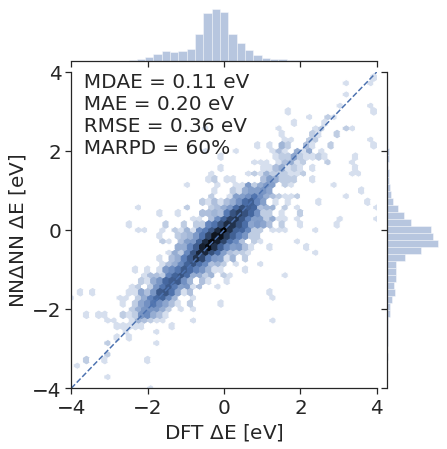

In [11]:
# Predict
targets_pred = net.predict(sdts_val)
residuals = targets_pred.flatten() - targets_val.flatten()

# Plot
lims = [-4, 4]
grid = sns.jointplot(targets_val.reshape(-1),
                     targets_pred.reshape(-1),
                     kind='hex',
                     bins='log',
                     extent=lims*2)
ax = grid.ax_joint
_ = ax.set_xlim(lims)
_ = ax.set_ylim(lims)
_ = ax.plot(lims, lims, '--')
_ = ax.set_xlabel('DFT $\Delta$E [eV]')
_ = ax.set_ylabel('%s $\Delta$E [eV]' % model_name)

# Calculate the error metrics
mae = mean_absolute_error(targets_val, targets_pred)
rmse = np.sqrt(mean_squared_error(targets_val, targets_pred))
mdae = median_absolute_error(targets_val, targets_pred)
marpd = np.abs(2 * residuals /
               (np.abs(targets_pred).reshape(-1)
                + np.abs(targets_val.reshape(-1)))
                ).mean() * 100
r2 = r2_score(targets_val, targets_pred)
corr = np.corrcoef(targets_val.reshape(-1), targets_pred.reshape(-1))[0, 1]

# Report
text = ('  MDAE = %.2f eV\n' % mdae + 
        '  MAE = %.2f eV\n' % mae + 
        '  RMSE = %.2f eV\n' % rmse + 
        '  MARPD = %i%%\n' % marpd)
print('R2 = %.2f' % r2)
print('PPMCC = %.2f' % corr)
_ = ax.text(x=lims[0], y=lims[1], s=text,
            horizontalalignment='left',
            verticalalignment='top',
            fontsize=fontsize)

In [12]:
%%cache calibration_val.pkl predicted_pi observed_pi stdevs targets_pred_err

# Predict errors on sdts_val (validation set)
targets_pred_err = net_err.predict(sdts_val).reshape(-1)
stdevs = targets_pred_err

# Computing calibration
def calculate_density(percentile):
    '''
    Calculate the fraction of the residuals that fall within the center
    `percentile` of their respective Gaussian distributions, which are
    defined by their respective uncertainty estimates.
    '''
    # Find the normalized bounds of this percentile
    lower_bound = stats.norm.ppf(0.5-percentile/2)
    upper_bound = stats.norm.ppf(0.5+percentile/2)

    # Normalize the residuals so they all should fall on the normal bell curve
    normalized_residuals = residuals.reshape(-1) / stdevs.reshape(-1)

    # Count how many residuals fall inside here
    num_within_quantile = 0
    for resid in normalized_residuals:
        if lower_bound <= resid <= upper_bound:
            num_within_quantile += 1

    # Return the fraction of residuals that fall within the bounds
    density = num_within_quantile / len(residuals)
    return density

predicted_pi = np.linspace(0, 1, 100)
observed_pi = [calculate_density(quantile)
               for quantile in tqdm_notebook(predicted_pi, desc='Calibration')]

[Saved variables 'observed_pi, predicted_pi, stdevs, targets_pred_err' to file '/zfsauton/home/willie/proj/uncertainty_benchmarking/NNdNN/calibration_val.pkl'.]



In [13]:
%matplotlib inline
import seaborn as sns


# Set figure defaults
width = 4  # Because it looks good
fontsize = 12
rc = {'figure.figsize': (width, width),
      'font.size': fontsize,
      'axes.labelsize': fontsize,
      'axes.titlesize': fontsize,
      'xtick.labelsize': fontsize,
      'ytick.labelsize': fontsize,
      'legend.fontsize': fontsize}
sns.set(rc=rc)
sns.set_style('ticks')

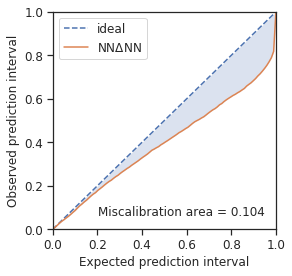

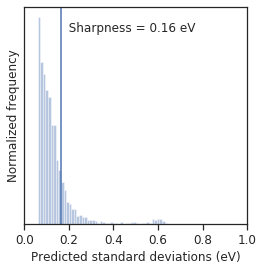

In [14]:
%matplotlib inline
from matplotlib import pyplot as plt
from shapely.geometry import Polygon, LineString
from shapely.ops import polygonize, unary_union


# Plot settings
figsize = (4, 4)

# Plot the calibration curve
fig_cal = plt.figure(figsize=figsize)
ax_ideal = sns.lineplot([0, 1], [0, 1], label='ideal')
_ = ax_ideal.lines[0].set_linestyle('--')
ax_gp = sns.lineplot(predicted_pi, observed_pi, label=model_name)
ax_fill = plt.fill_between(predicted_pi, predicted_pi, observed_pi,
                           alpha=0.2, label='miscalibration area')
_ = ax_ideal.set_xlabel('Expected prediction interval')
_ = ax_ideal.set_ylabel('Observed prediction interval')
_ = ax_ideal.set_xlim([0, 1])
_ = ax_ideal.set_ylim([0, 1])

# Calculate the miscalibration area.
polygon_points = []
for point in zip(predicted_pi, observed_pi):
    polygon_points.append(point)
for point in zip(reversed(predicted_pi), reversed(predicted_pi)):
    polygon_points.append(point)
polygon_points.append((predicted_pi[0], observed_pi[0]))
polygon = Polygon(polygon_points)
x, y = polygon.exterior.xy # original data
ls = LineString(np.c_[x, y]) # closed, non-simple
lr = LineString(ls.coords[:] + ls.coords[0:1])
mls = unary_union(lr)
polygon_area_list =[poly.area for poly in polygonize(mls)]
miscalibration_area = np.asarray(polygon_area_list).sum()

# Annotate the plot with the miscalibration area
plt.text(x=0.95, y=0.05,
         s='Miscalibration area = %.3f' % miscalibration_area,
         verticalalignment='bottom',
         horizontalalignment='right',
         fontsize=fontsize)

# Plot sharpness curve
xlim = [0., 1.]
fig_sharp = plt.figure(figsize=figsize)
ax_sharp = sns.distplot(stdevs, kde=False, norm_hist=True)
ax_sharp.set_xlim(xlim)
ax_sharp.set_xlabel('Predicted standard deviations (eV)')
ax_sharp.set_ylabel('Normalized frequency')
ax_sharp.set_yticklabels([])
ax_sharp.set_yticks([])

# Calculate and report sharpness
sharpness = np.sqrt(np.mean(stdevs**2))
_ = ax_sharp.axvline(x=sharpness, label='sharpness')
if sharpness < (xlim[0] + xlim[1]) / 2:
    text = '\n  Sharpness = %.2f eV' % sharpness
    h_align = 'left'
else:
    text = '\nSharpness = %.2f eV  ' % sharpness
    h_align = 'right'
_ = ax_sharp.text(x=sharpness, y=ax_sharp.get_ylim()[1],
                  s=text,
                  verticalalignment='top',
                  horizontalalignment=h_align,
                  fontsize=fontsize)

In [15]:
# To confirm: another way to approximate the miscalibration area
np.mean(np.abs(predicted_pi - np.array(observed_pi)))

0.10324687075855835

## Test
We never actually made the predictions during the job, so we have to make the predictions here.

In [16]:
%matplotlib inline
import seaborn as sns


# Set figure defaults
width = 7.5/3  # 1/3 of a page
fontsize = 20
rc = {'figure.figsize': (width, width),
      'font.size': fontsize,
      'axes.labelsize': fontsize,
      'axes.titlesize': fontsize,
      'xtick.labelsize': fontsize,
      'ytick.labelsize': fontsize,
      'legend.fontsize': fontsize}
sns.set(rc=rc)
sns.set_style('ticks')

R2 = 0.80
PPMCC = 0.89


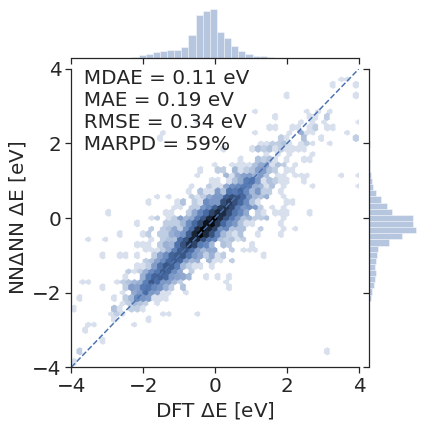

In [17]:
# Predict
targets_pred = net.predict(sdts_test)
residuals = targets_pred.flatten() - targets_test.flatten()

# Plot
lims = [-4, 4]
grid = sns.jointplot(targets_test.reshape(-1),
                     targets_pred.reshape(-1),
                     kind='hex',
                     bins='log',
                     extent=lims*2)
ax = grid.ax_joint
_ = ax.set_xlim(lims)
_ = ax.set_ylim(lims)
_ = ax.plot(lims, lims, '--')
_ = ax.set_xlabel('DFT $\Delta$E [eV]')
_ = ax.set_ylabel('%s $\Delta$E [eV]' % model_name)

# Calculate the error metrics
mae = mean_absolute_error(targets_test, targets_pred)
rmse = np.sqrt(mean_squared_error(targets_test, targets_pred))
mdae = median_absolute_error(targets_test, targets_pred)
marpd = np.abs(2 * residuals /
               (np.abs(targets_pred).reshape(-1)
                + np.abs(targets_test.reshape(-1)))
                ).mean() * 100
r2 = r2_score(targets_test, targets_pred)
corr = np.corrcoef(targets_test.reshape(-1), targets_pred.reshape(-1))[0, 1]

# Report
text = ('  MDAE = %.2f eV\n' % mdae + 
        '  MAE = %.2f eV\n' % mae + 
        '  RMSE = %.2f eV\n' % rmse + 
        '  MARPD = %i%%\n' % marpd)
print('R2 = %.2f' % r2)
print('PPMCC = %.2f' % corr)
_ = ax.text(x=lims[0], y=lims[1], s=text,
            horizontalalignment='left',
            verticalalignment='top',
            fontsize=fontsize)

# Save figure
plt.savefig('parity.pdf', dpi=300, bbox_inches='tight', transparent=True)

In [18]:
%%cache calibration_test.pkl predicted_pi observed_pi stdevs targets_pred_err

# Predict errors on sdts_test (test set)
targets_pred_err = net_err.predict(sdts_test).reshape(-1)
stdevs = targets_pred_err

# Computing calibration
def calculate_density(percentile):
    '''
    Calculate the fraction of the residuals that fall within the center
    `percentile` of their respective Gaussian distributions, which are
    defined by their respective uncertainty estimates.
    '''
    # Find the normalized bounds of this percentile
    lower_bound = stats.norm.ppf(0.5-percentile/2)
    upper_bound = stats.norm.ppf(0.5+percentile/2)

    # Normalize the residuals so they all should fall on the normal bell curve
    normalized_residuals = residuals.reshape(-1) / stdevs.reshape(-1)

    # Count how many residuals fall inside here
    num_within_quantile = 0
    for resid in normalized_residuals:
        if lower_bound <= resid <= upper_bound:
            num_within_quantile += 1

    # Return the fraction of residuals that fall within the bounds
    density = num_within_quantile / len(residuals)
    return density

predicted_pi = np.linspace(0, 1, 100)
observed_pi = [calculate_density(quantile)
               for quantile in tqdm_notebook(predicted_pi, desc='Calibration')]

[Saved variables 'observed_pi, predicted_pi, stdevs, targets_pred_err' to file '/zfsauton/home/willie/proj/uncertainty_benchmarking/NNdNN/calibration_test.pkl'.]



In [19]:
%matplotlib inline
import seaborn as sns


# Set figure defaults
width = 4  # Because it looks good
fontsize = 12
rc = {'figure.figsize': (width, width),
      'font.size': fontsize,
      'axes.labelsize': fontsize,
      'axes.titlesize': fontsize,
      'xtick.labelsize': fontsize,
      'ytick.labelsize': fontsize,
      'legend.fontsize': fontsize}
sns.set(rc=rc)
sns.set_style('ticks')

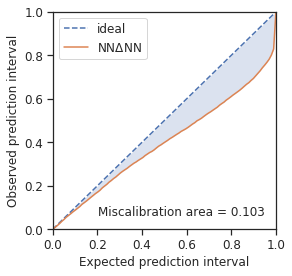

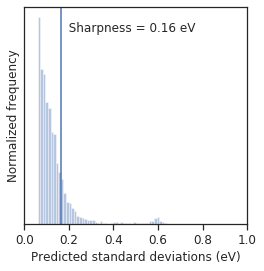

In [20]:
%matplotlib inline
from matplotlib import pyplot as plt
from shapely.geometry import Polygon, LineString
from shapely.ops import polygonize, unary_union


# Plot settings
figsize = (4, 4)

# Plot the calibration curve
fig_cal = plt.figure(figsize=figsize)
ax_ideal = sns.lineplot([0, 1], [0, 1], label='ideal')
_ = ax_ideal.lines[0].set_linestyle('--')
ax_gp = sns.lineplot(predicted_pi, observed_pi, label=model_name)
ax_fill = plt.fill_between(predicted_pi, predicted_pi, observed_pi,
                           alpha=0.2, label='miscalibration area')
_ = ax_ideal.set_xlabel('Expected prediction interval')
_ = ax_ideal.set_ylabel('Observed prediction interval')
_ = ax_ideal.set_xlim([0, 1])
_ = ax_ideal.set_ylim([0, 1])

# Calculate the miscalibration area.
polygon_points = []
for point in zip(predicted_pi, observed_pi):
    polygon_points.append(point)
for point in zip(reversed(predicted_pi), reversed(predicted_pi)):
    polygon_points.append(point)
polygon_points.append((predicted_pi[0], observed_pi[0]))
polygon = Polygon(polygon_points)
x, y = polygon.exterior.xy # original data
ls = LineString(np.c_[x, y]) # closed, non-simple
lr = LineString(ls.coords[:] + ls.coords[0:1])
mls = unary_union(lr)
polygon_area_list =[poly.area for poly in polygonize(mls)]
miscalibration_area = np.asarray(polygon_area_list).sum()

# Annotate the plot with the miscalibration area
plt.text(x=0.95, y=0.05,
         s='Miscalibration area = %.3f' % miscalibration_area,
         verticalalignment='bottom',
         horizontalalignment='right',
         fontsize=fontsize)

# Save
plt.savefig('calibration.pdf', dpi=300, bbox_inches='tight', transparent=True)


# Plot sharpness curve
xlim = [0., 1.]
fig_sharp = plt.figure(figsize=figsize)
ax_sharp = sns.distplot(stdevs, kde=False, norm_hist=True)
ax_sharp.set_xlim(xlim)
ax_sharp.set_xlabel('Predicted standard deviations (eV)')
ax_sharp.set_ylabel('Normalized frequency')
ax_sharp.set_yticklabels([])
ax_sharp.set_yticks([])

# Calculate and report sharpness
sharpness = np.sqrt(np.mean(stdevs**2))
_ = ax_sharp.axvline(x=sharpness, label='sharpness')
if sharpness < (xlim[0] + xlim[1]) / 2:
    text = '\n  Sharpness = %.2f eV' % sharpness
    h_align = 'left'
else:
    text = '\nSharpness = %.2f eV  ' % sharpness
    h_align = 'right'
_ = ax_sharp.text(x=sharpness, y=ax_sharp.get_ylim()[1],
                  s=text,
                  verticalalignment='top',
                  horizontalalignment=h_align,
                  fontsize=fontsize)

# Save
plt.savefig('sharpness.pdf', dpi=300, bbox_inches='tight', transparent=True)

In [21]:
# To confirm: another way to approximate the miscalibration area
np.mean(np.abs(predicted_pi - np.array(observed_pi)))

0.10209192906261313

# Negative Log-likelihood (NLL)
We also compute the negative log-likelihood as an additional metric that captures both predictive accuracy and quality of uncertainty quantification.

In [22]:
from scipy.stats import norm


nll_list = []
for (res, std) in zip(residuals, stdevs):
    nll_list.append(norm.logpdf(res, scale=std))

nll = -1 * np.sum(nll_list)

print('NLL = {}'.format(nll))

NLL = 18605.318363293667


# Error-bar figure
We concede that calibration curves and sharpness distributions are new concepts in the field of catalysis, and that a simple parity plot with error bars is more intuitive. As such, we create a few examples of error bar parities to help readers connect those incumbent ideas with the newer ideas of calibration and sharpness.

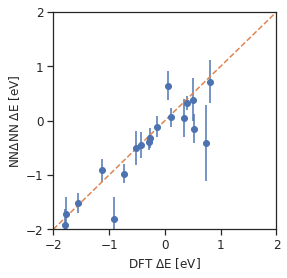

In [23]:
import random
import numpy as np
import matplotlib.pyplot as plt


# Pull a random sample of the data, because plotting thousands of these at once would look absurd
all_predictions = list(zip(targets_pred.flatten(), targets_test.flatten(), stdevs))
samples = random.sample(all_predictions, k=20)

# Parse the samples
_preds, _targets, _stdevs = zip(*samples)
_preds = np.array(_preds)
_targets = np.array(_targets)
_stdevs = np.array(_stdevs)

# Plot
fig = plt.figure(figsize=(4, 4))
_ = plt.errorbar(_targets, _preds, yerr=2*_stdevs, fmt='o')
ax = plt.gca()

# Make a parity line
lims = [-2, 2]
_ = ax.plot(lims, lims, '--')

# Format
_ = ax.set_xlim(lims)
_ = ax.set_ylim(lims)
_ = ax.set_xticks(list(range(-2, 3)))
_ = ax.set_yticks(list(range(-2, 3)))
_ = ax.set_xlabel('DFT $\Delta$E [eV]')
_ = ax.set_ylabel('%s $\Delta$E [eV]' % model_name)

# Save
_ = plt.savefig('error_bar_parity.pdf', dpi=300, bbox_inches='tight', transparent=True)